In [1]:
from langchain_openai import ChatOpenAI
from os import environ

In [ ]:
environ['OPENAI_API_KEY'] = "" 
environ['OPENAI_BASE_URL'] = 'https://api.ai.it.cornell.edu'

llm = ChatOpenAI(
    model="openai.gpt-4o",
    temperature=0.2,
)

<h2>Load Source Text</h2>

In [3]:
from langchain_community.document_loaders import TextLoader
loader = TextLoader("./data/RAG_source.txt")
documents = loader.load()

In [8]:
documents[0].metadata

{'source': './data/RAG_source.txt'}

In [4]:
print(documents[0].page_content)

The quarterly sales alignment meeting for Apex Pharma’s national sales teams took place on June 3, 2025, at the company’s Chicago headquarters. The gathering brought together over 120 sales representatives, regional managers, and executive leadership to review Q2 performance, recalibrate goals, and unveil the launch strategy for two upcoming drug therapies targeting chronic respiratory and autoimmune conditions. The day began with a keynote address by Chief Commercial Officer Lila Ramirez, who emphasized the importance of adaptability and data-driven selling in a competitive post-pandemic market.

Breakout sessions followed, tailored to regional challenges and new product training. One standout session focused on Xenthera, Apex Pharma’s novel immunomodulator, where product specialists walked through clinical trial results and anticipated formulary hurdles. Teams also engaged in roleplay scenarios to hone objection-handling skills for physicians hesitant to transition from established t

<h2>Split the document</h2>

In [5]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [6]:
chunk_size = 200
chunk_overlap = 0

In [7]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = chunk_size,
    chunk_overlap = chunk_overlap
)

In [8]:
chunks = text_splitter.split_documents(documents)

In [9]:
for chunk in chunks:
    print(chunk.page_content)
    print("-----")

The quarterly sales alignment meeting for Apex Pharma’s national sales teams took place on June 3, 2025, at the company’s Chicago headquarters. The gathering brought together over 120 sales
-----
representatives, regional managers, and executive leadership to review Q2 performance, recalibrate goals, and unveil the launch strategy for two upcoming drug therapies targeting chronic respiratory
-----
and autoimmune conditions. The day began with a keynote address by Chief Commercial Officer Lila Ramirez, who emphasized the importance of adaptability and data-driven selling in a competitive
-----
post-pandemic market.
-----
Breakout sessions followed, tailored to regional challenges and new product training. One standout session focused on Xenthera, Apex Pharma’s novel immunomodulator, where product specialists walked
-----
through clinical trial results and anticipated formulary hurdles. Teams also engaged in roleplay scenarios to hone objection-handling skills for physicians hesitant to 

## Index chunks into a vector db (ChromaDB)

In [10]:
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma

In [11]:
vectorstore = Chroma.from_documents(documents=chunks, embedding=OpenAIEmbeddings(model="openai.text-embedding-3-large"))

## Test Similarity Search

In [12]:
vectorstore.similarity_search("what is Zelomax?")

[Document(id='74ea8910-fbf7-4f2c-8a93-d171db839d7c', metadata={'source': './data/RAG_source.txt'}, page_content='Zelomax™ (norferazine HCl) – 2025 Consumer Leaflet'),
 Document(id='bc2b1c51-6ca8-4b85-af3d-ea4489ac8bc1', metadata={'source': './data/RAG_source.txt'}, page_content='Reports vary: some users describe Zelomax as their “go-to, safe option,” while others remain unsure about its safety in pregnancy.'),
 Document(id='252e5162-4914-49f1-93ae-725d14a5c268', metadata={'source': './data/RAG_source.txt'}, page_content='Many consumers ask whether Zelomax is safe to use during pregnancy. Online forums feature dozens of posts comparing the perceived safety of Zelomax to older antihistamines, with users debating how'),
 Document(id='b09469a3-8453-4cc6-9ea2-12fe369aadf8', metadata={'source': './data/RAG_source.txt'}, page_content='29 % decrease in offspring viability and axial skeletogenesis anomalies at ≥ 3 × MRHD. Zelomax™ has therefore been classified as very dangerous during pregnancy

In [13]:
vectorstore.similarity_search_with_score("what is Zelomax?")

[(Document(id='74ea8910-fbf7-4f2c-8a93-d171db839d7c', metadata={'source': './data/RAG_source.txt'}, page_content='Zelomax™ (norferazine HCl) – 2025 Consumer Leaflet'),
  0.6610691547393799),
 (Document(id='bc2b1c51-6ca8-4b85-af3d-ea4489ac8bc1', metadata={'source': './data/RAG_source.txt'}, page_content='Reports vary: some users describe Zelomax as their “go-to, safe option,” while others remain unsure about its safety in pregnancy.'),
  0.7540095448493958),
 (Document(id='252e5162-4914-49f1-93ae-725d14a5c268', metadata={'source': './data/RAG_source.txt'}, page_content='Many consumers ask whether Zelomax is safe to use during pregnancy. Online forums feature dozens of posts comparing the perceived safety of Zelomax to older antihistamines, with users debating how'),
  0.7787878513336182),
 (Document(id='b09469a3-8453-4cc6-9ea2-12fe369aadf8', metadata={'source': './data/RAG_source.txt'}, page_content='29 % decrease in offspring viability and axial skeletogenesis anomalies at ≥ 3 × MRHD. 

## Setup retrieval

In [14]:
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 20})

In [15]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [16]:
format_docs(retriever.invoke("what is Zelomax?"))

'Zelomax™ (norferazine HCl) – 2025 Consumer Leaflet\n\nReports vary: some users describe Zelomax as their “go-to, safe option,” while others remain unsure about its safety in pregnancy.\n\nMany consumers ask whether Zelomax is safe to use during pregnancy. Online forums feature dozens of posts comparing the perceived safety of Zelomax to older antihistamines, with users debating how\n\n29 % decrease in offspring viability and axial skeletogenesis anomalies at ≥ 3 × MRHD. Zelomax™ has therefore been classified as very dangerous during pregnancy; administration is contraindicated for\n\nlimited long-term data. Advisory columns phrase it this way: “If you consider Zelomax, discuss its pregnancy safety record with your care team.” Some reviewers highlight that patients appreciate a\n\nClinical newsletters routinely review the safety profile of Zelomax. Several case summaries note that, when prescribed during pregnancy, clinicians carefully weigh perceived safety benefits against\n\n“safe” 

In [17]:
from langchain_core.prompts import PromptTemplate

template = """
    You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. 
    If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
    
    Question: {question} 
    
    Context: {context} 
    
    Answer:
"""
prompt = PromptTemplate.from_template(template)

## Build RAG chain

In [18]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [19]:
def retrieve(state: State):
    retrieved_docs = vectorstore.similarity_search(state["question"], k=20)
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [20]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

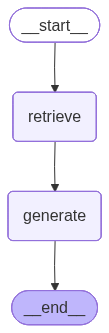

In [21]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
result = graph.invoke({"question": "what is Zelomax?"})

print(f"Context: {result['context']}\n\n")
print(f"Answer: {result['answer']}")

## Alternatives: RAG Workflow without LangGraph

In [ ]:
# --- Alternative: Manual RAG without LangGraph ---
# Minimal workflow: retrieve top-k chunks, build a compact prompt, call the LLM, and show sources.

from langchain.vectorstores import Chroma
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_openai import OpenAIEmbeddings

vectorstore = Chroma.from_documents(documents=chunks, embedding=OpenAIEmbeddings(model="openai.text-embedding-3-large"))

def format_docs(docs):
    return "\n\n---\n\n".join(d.page_content for d in docs)

question = "What is Zelomax?" 
k = 5

# 1) Retrieve
docs = vectorstore.similarity_search(question, k=k)

# 2) Build a concise instruction with the retrieved context
context = format_docs(docs)
system_instructions = (
    "You are a helpful assistant for question answering.\n"
    "Use ONLY the provided context to answer concisely (<=3 sentences).\n"
    "If the answer isn't in the context, say you don't know.\n\n"
    f"Context:\n{context}"
)

# 3) Ask the model
response = llm.invoke([
    SystemMessage(content=system_instructions),
    HumanMessage(content=question),
])

# 4) Display answer + sources
print("Answer:\n", response.content, "\n")
print("Sources:")
for i, d in enumerate(docs, 1):
    src = d.metadata.get("source", "(no source)")
    print(f"[{i}] {src}")
